<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/epacuit/introduction-machine-learning/blob/main/first-steps/linear-classification-algorithms.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(linear-classification-algorithms)=
# Finding a Decision Boundary

In this tutorial, we will learn how to find the decision boundary of a linear classifier. We will explore three different approaches:

1. **Random Search** - A simple baseline approach where we randomly generate weight vectors 
   and choose the one with the best accuracy.
2. **Perceptron Algorithm** - A classic online learning method that iteratively updates weights 
   based on misclassified points.
3. **Support Vector Machines (SVMs)** - A more advanced method that finds the optimal decision boundary by maximizing the *margin* between classes.

Each approach has different strengths and weaknesses, and by the end of this tutorial, you will understand the differences and advantages of each method.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Helper Functions

Before we start, let's define some helper functions that will be used throughout the tutorial.  

```{tip}
You can skip this section on a first read.
```



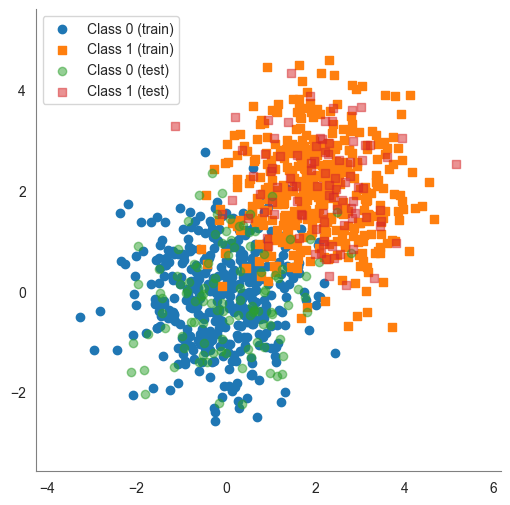

In [2]:
# Set random seed for reproducibility
# np.random.seed(42)

def generate_labeled_data(class0_center, class1_center, num_points=1000):
    """
    Generate labeled data for a binary classification problem.

    Parameters
    ----------
    class0_center : list
        The center of the points for class 0.
    class1_center : list
        The center of the points for class 1.
    num_points : int
        The total number of points to generate.

    Returns
    -------
    X : ndarray
        The feature matrix of shape (num_points, 2).
    y : ndarray
        The labels of shape (num_points), where each label is either 0 or 1.
    """
    class0_center = np.array(class0_center)
    class1_center = np.array(class1_center)

    # Generate points for Class 0 and Class 1
    class0 = np.random.randn(num_points // 2, 2) + class0_center
    class1 = np.random.randn(num_points // 2, 2) + class1_center

    # Combine into one dataset
    X = np.vstack([class0, class1])
    y = np.array([0] * (num_points // 2) + [1] * (num_points // 2))  # Labels: 0 and 1
    # Shuffle dataset
    indices = np.random.permutation(num_points)
    X = X[indices]
    y = y[indices]

    return X, y
num_points = 1000
X, y = generate_labeled_data(
    class0_center=[0, 0], 
    class1_center=[2, 2], 
    num_points=num_points)

# Split data into training and testing sets
split_idx = int(0.8 * num_points)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Plot the data

sns.set_style(style='white')
plt.figure(figsize=(6, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], marker='o', label='Class 0 (train)')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], marker='s', label='Class 1 (train)')
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], marker='o', alpha=0.5, label='Class 0 (test)')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], marker='s', alpha=0.5, label='Class 1 (test)')
plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
sns.despine()
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

plt.legend()
plt.show()

In [3]:
def plot_with_boundary(X, y, weights, b):
    """
    Plot the decision boundary of a binary classifier along with the data.

    Parameters
    ----------
    X : ndarray
        The feature matrix of shape (num_points, 2).
    y : ndarray
        The labels of shape (num_points), where each label is either 0 or 1.
    weights : list or numpy.array of length 2
        The weights of the decision boundary.
    b : float
        The bias term of the decision boundary.
    """
    w1, w2 = weights
    X = X.copy()
    y = y.copy()
    class0 = X[y == 0]
    class1 = X[y == 1]
    x_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    if abs(w2) < 1e-6:
        y_vals = np.full_like(x_vals, -b)  # Vertical line at -b
    else:
        y_vals = -(w1 / w2) * x_vals - (b / w2)

    # Compute predictions
    predictions = np.sign(w1 * X[:, 0] + w2 * X[:, 1] + b)
    y[y == 0] = -1
    misclassified = predictions != y
    accuracy = np.mean(predictions == y)

    sns.set_style('white')
    plt.figure(figsize=(6, 6))
    plt.scatter(class0[:, 0], class0[:, 1], marker='o', label='Class 0')
    plt.scatter(class1[:, 0], class1[:, 1], marker='s', label='Class 1')

    plt.scatter(X[misclassified, 0], X[misclassified, 1], 
                color='black', marker='x', s=100, label="Misclassified")  # Fix warning
    plt.plot(x_vals, y_vals, 'g--', linewidth=2)  # Green dashed line for boundary
    
    # Compute midpoint of the decision boundary for normal vector placement
    mid_x = (X[:, 0].min() + X[:, 0].max()) / 2
    mid_y = -(w1 / w2) * mid_x - (b / w2) if abs(w2) > 1e-6 else -b

    # Normalize normal vector to a fixed length
    normal_length = 1.0
    norm = np.sqrt(w1**2 + w2**2)
    if norm > 0:
        unit_w1, unit_w2 = (w1 / norm) * normal_length, (w2 / norm) * normal_length
        plt.arrow(mid_x, mid_y, unit_w1, unit_w2, color='purple', head_width=0.2, head_length=0.2, label="Normal Vector")
    
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    sns.despine()
    plt.gca().spines['left'].set_color('gray')
    plt.gca().spines['bottom'].set_color('gray')
    plt.title(f"Decision Boundary: ${w1:.2f}*x_1 + {w2:.2f}*x_2 + {b:.2f} = 0$\nAccuracy: {accuracy:.2%}\n")
    # don't show the line for the normal vector
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles=handles[:-1], 
        labels=labels[:-1],
        loc='center left', 
        bbox_to_anchor=(1, 0.5))
    plt.show()

In [4]:
def project_point_onto_boundary(point, w, b):
    """
    Compute the perpendicular projection of a point onto the decision boundary.
    """
    norm_w = w / np.linalg.norm(w)
    distance = (np.dot(point, w) + b) / np.linalg.norm(w)
    projection = point - distance * norm_w
    return projection

# Function to plot dataset and decision boundary with margins
def plot_with_boundary_and_margin(X, y, weights, b):
    """
    Plot the decision boundary of a binary classifier along with the data and margins, and include the margin distance of each point.
    """

    # Function to calculate the margin (distance) of each data point to the decision boundary
    def calculate_margin(X, w, b):
        return np.abs(X.dot(w) + b) / np.linalg.norm(w)
    X = X.copy()
    y = y.copy()
    w1, w2 = weights
    class0 = X[y == 0]
    class1 = X[y == 1]
    x_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    if abs(w2) < 1e-6:
        y_vals = np.full_like(x_vals, -b)  # Vertical line at -b
    else:
        y_vals = -(w1 / w2) * x_vals - (b / w2)

    # Compute predictions
    predictions = np.sign(w1 * X[:, 0] + w2 * X[:, 1] + b)
    y[y == 0] = -1
    misclassified = predictions != y
    accuracy = np.mean(predictions == y)

    sns.set_style('white')
    plt.figure(figsize=(6, 6))
    plt.scatter(class0[:, 0], class0[:, 1], marker='o', label='Class 0')
    plt.scatter(class1[:, 0], class1[:, 1], marker='s', label='Class 1')
    
    plt.scatter(X[misclassified, 0], X[misclassified, 1], 
                color='black', marker='x', s=100, label="Misclassified")
    plt.plot(x_vals, y_vals, 'g--', linewidth=2)  # Green dashed line for boundary
    
    # Compute margin lines
    margins = calculate_margin(X, np.array([w1, w2]), b)
    margin_lines = [(X[i], project_point_onto_boundary(X[i], np.array([w1, w2]), b)) for i in range(len(X))]
    
    for i, (point, proj) in enumerate(margin_lines):
        plt.plot([point[0], proj[0]], [point[1], proj[1]], 'orange', linestyle='dotted', alpha=0.7)
        plt.text(point[0], point[1], f'{margins[i]:.2f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right', color='black')
    
    # Compute midpoint of the decision boundary for normal vector placement
    mid_x = (X[:, 0].min() + X[:, 0].max()) / 2
    mid_y = -(w1 / w2) * mid_x - (b / w2) if abs(w2) > 1e-6 else -b

    # Normalize normal vector to a fixed length
    normal_length = 1.0
    norm = np.sqrt(w1**2 + w2**2)
    if norm > 0:
        unit_w1, unit_w2 = (w1 / norm) * normal_length, (w2 / norm) * normal_length
        plt.arrow(mid_x, mid_y, unit_w1, unit_w2, color='purple', head_width=0.2, head_length=0.2, label="Normal Vector")
    
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    sns.despine()
    plt.gca().spines['left'].set_color('gray')
    plt.gca().spines['bottom'].set_color('gray')
    plt.title(f"Decision Boundary: ${w1:.2f}*x_1 + {w2:.2f}*x_2 + {b:.2f} = 0$\n Accuracy: {accuracy:.2%}")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles=handles[:-1], 
        labels=labels[:-1],
        loc='center left', 
        bbox_to_anchor=(1, 0.5))
    plt.show()


## Random Search: A Baseline Approach

The simplest way to find a decision boundary is through **random search**. In this approach, we randomly generate weight vectors and biases multiple times and select the one that yields the 
highest accuracy on the training data.

This method is inefficient and does not guarantee an optimal solution, but it serves as a useful baseline to compare against more sophisticated learning algorithms. By understanding its limitations, we can better appreciate the advantages of other algorithms.


In [5]:

def evaluate_accuracy(y_true, y_pred):
    """
    Computes the classification accuracy, which is the proportion of 
    correctly predicted labels.
    """
    return np.mean(y_true == y_pred)

def train_random_search(X_train, y_train, num_trials=1000):
    """
    Performs random search to find a linear decision boundary. 
    The function generates random weight vectors and biases, evaluates accuracy, and selects the best-performing model.

    """

    best_w, best_b = None, None
    best_accuracy = 0  # Start with the lowest possible accuracy
    
    for _ in range(num_trials):
        w = np.random.randn(2)  # Random weight vector
        b = np.random.randn()  # Random bias
        
        scores = X_train.dot(w) + b
        y_pred = (scores >= 0).astype(int) 
        
        accuracy = np.mean(y_train == y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_w = w
            best_b = b
    
    def model(X_new):
        scores = X_new.dot(best_w) + best_b
        return (scores >= 0).astype(int)  
    
    return model, best_w, best_b, best_accuracy

Best weights: [1.59242778 2.01737358],
Best bias: 0.36002115400388934,
Best accuracy: 0.92875
Test accuracy: 0.95


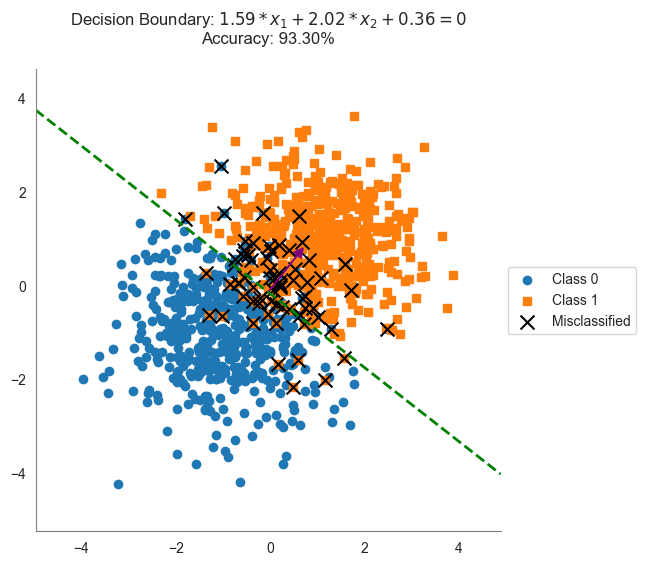

In [6]:

num_points = 1000
X, y = generate_labeled_data(
    class0_center=[-1, -1], 
    class1_center=[1, 1], 
    num_points=num_points)

# Split data into training and testing sets
split_idx = int(0.8 * num_points)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train the random search model
random_model, best_w, best_b, best_accuracy = train_random_search(X_train, y_train, num_trials = 10000)

print(f"Best weights: {best_w},\nBest bias: {best_b},\nBest accuracy: {best_accuracy}")

# Evaluate the model on the test set
y_pred = random_model(X_test)
test_accuracy = evaluate_accuracy(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")

# concatenate X_train and X_test and the labels   
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
plot_with_boundary(X, y, best_w, best_b)

A key limitation of the random search approach is that it requires a large number of random samples to find a good solution. Even then, it may not identify the **optimal** decision boundary.

To illustrate this, consider a simple example where two classes are linearly separable. Ideally, a perfect classifier should achieve 100% accuracy. However, since random search relies on trial and error, it may fail to find this optimal boundary, even with a large number of trials.

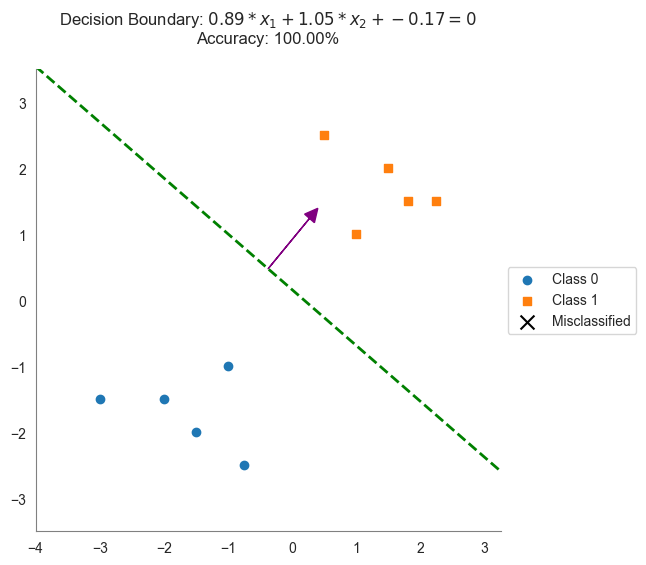

In [7]:
X1 = np.array([
    [-1, -1], [-2, -1.5], [-1.5, -2], [-0.75, -2.5], [-3, -1.5],  # Class 0
    [1, 1], [2.25, 1.5], [1.5, 2], [0.5, 2.5], [1.8, 1.5]  # Class 1
])
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])  # Labels

random_model, best_w, best_b, best_accuracy = train_random_search(X1, y1, num_trials=10)

plot_with_boundary(X1, y1, best_w, best_b)

## Perceptron Algorithm

While random search provides a basic way to find a decision boundary, it does not learn from the data.  The **Perceptron Algorithm**, introduced by Frank Rosenblatt in 1958, is one of the earliest learning 
algorithms that iteratively improves its decision boundary.

Unlike random search, the Perceptron algorithm adjusts its weights systematically. It starts with random weights and updates them each time a misclassified point is encountered. This process continues until all 
points are correctly classified (if the data is linearly separable).

The key idea behind the Perceptron is simple: 
- If a point is **correctly classified**, do nothing.
- If a point is **misclassified**, adjust the weight vector to move the boundary in the right direction.

The Perceptron algorithm is guaranteed to converge if the data is linearly separable. However, if the data is not linearly separable, the algorithm will not converge, and the weights will continue to update indefinitely.

In [8]:
def train_perceptron(X, y, max_iters=1000):
    """
    Use the perceptron algorithm to find a linear decision boundary.
    """
    
    w = np.zeros(X.shape[1])  # Initialize weight vector
    b = 0  # Initialize bias
    y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}
    
    for _ in range(max_iters):
        misclassified = False
        for i in range(len(X)):
            if y[i] * (np.dot(w, X[i]) + b) <= 0:  # Misclassification check
                w += y[i] * X[i]  # Update weights
                b += y[i]  # Update bias
                misclassified = True
        if not misclassified:  # Stop if no misclassifications
            break
    
    def model(X_new):
        scores = X_new.dot(w) + b
        return (scores >= 0).astype(int)
    
    return model, w, b



Perceptron weights: [3.00532466 2.5397653 ],
Perceptron bias: -1
Test accuracy: 1.0


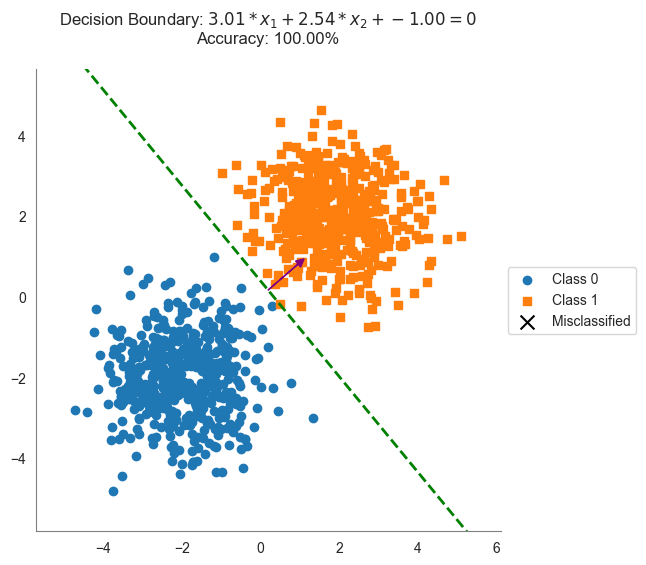

In [9]:
num_points = 1000
X, y = generate_labeled_data(
    class0_center=[-2, -2], 
    class1_center=[2, 2], 
    num_points=num_points)

# Split data into training and testing sets
split_idx = int(0.8 * num_points)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train the random search model
perceptron_model, best_w, best_b = train_perceptron(X_train, y_train)

print(f"Perceptron weights: {best_w},\nPerceptron bias: {best_b}")

# Evaluate the model on the test set
y_pred = random_model(X_test)
test_accuracy = evaluate_accuracy(y_test, y_pred)
print(f"Test accuracy: {test_accuracy}")

# concatenate X_train and X_test and the labels   
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

plot_with_boundary(X, y, best_w, best_b)

## Comparing Decision Boundaries

One of the key limitations of the Perceptron algorithm is that it only ensures points are classified correctly—it does not consider how confidently they are classified. In other words, while it finds a separating boundary, it does not maximize the distance between the closest data points and the decision boundary.

To illustrate this, consider a simple example where two classes are linearly separable. There are multiple decision boundaries that correctly classify all points, but not all boundaries are equally desirable. One of them—represented by the blue line—is preferable because it is more robust and generalizable to new data.


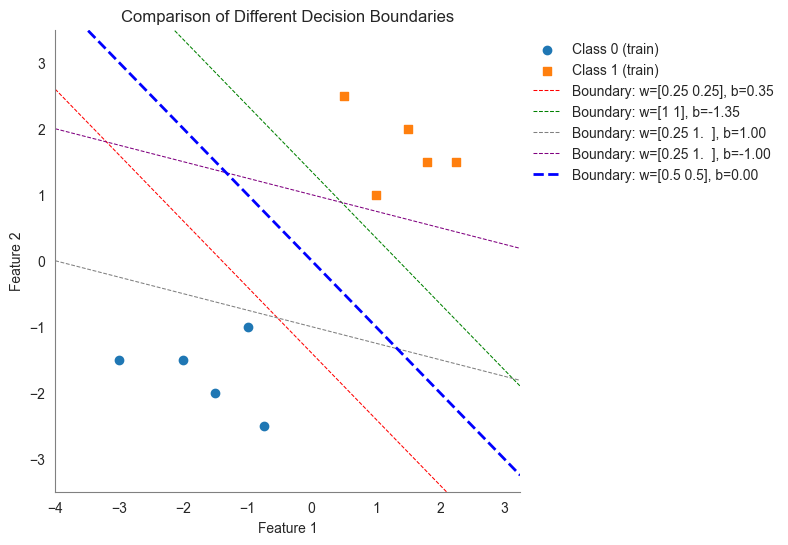

In [10]:
X1 = np.array([
    [-1, -1], [-2, -1.5], [-1.5, -2], [-0.75, -2.5], [-3, -1.5],  # Class 0
    [1, 1], [2.25, 1.5], [1.5, 2], [0.5, 2.5], [1.8, 1.5]  # Class 1
])
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])  # Labels


sns.set_style('white')
plt.figure(figsize=(6, 6))

plt.scatter(X1[y1 == 0][:, 0], X1[y1 == 0][:, 1], marker='o', label='Class 0 (train)')
plt.scatter(X1[y1 == 1][:, 0], X1[y1 == 1][:, 1], marker='s', label='Class 1 (train)')
plt.ylim(X1[:, 1].min() - 1, X1[:, 1].max() + 1)
plt.xlim(X1[:, 0].min() - 1, X1[:, 0].max() + 1)

boundaries = [
    {'w': np.array([0.25, 0.25]), 'b': 0.35}, 
    {'w': np.array([1, 1]), 'b': -1.35},   
    {'w': np.array([0.25, 1.0]), 'b': 1},   
    {'w': np.array([0.25, 1.0]), 'b': -1},   
]

boundary_colors = ['red', 'green', 'gray', 'purple']
x_vals = np.linspace(X1[:, 0].min() - 1, X1[:, 0].max() + 1, 100)
for bidx, boundary in enumerate(boundaries):
    w, b = boundary['w'], boundary['b']
    y_vals = -(w[0] / w[1]) * x_vals - (b / w[1])
    plt.plot(x_vals, y_vals, linestyle='--', color=boundary_colors[bidx],  lw=0.75, label=f'Boundary: w={w}, b={b:.2f}')

w, b = np.array([0.5, 0.5]),0.0
y_vals = -(w[0] / w[1]) * x_vals - (b / w[1])
plt.plot(x_vals, y_vals, linestyle='--', color="blue",  lw=2, label=f'Boundary: w={w}, b={b:.2f}')

sns.despine()
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)  
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Comparison of Different Decision Boundaries")
plt.show();


In classification problems, the **margin** measures how far a given data point is from the decision boundary. More precisely, it is the shortest distance from the data point to the boundary that separates different classes.

* If the margin is large, the classification is considered more confident and stable.
* If the margin is small, the point is close to the decision boundary and may be more likely to be misclassified.

The margin is always measured perpendicularly to the decision boundary, as this is the shortest possible distance.

The graph below shows the margin for each data point for the decision boundary generated by the perceptron algorithm. The margin is the distance from the decision boundary to the closest point in each class.

#### Calculating the Margin

Suppose that the decision boundary defined by the equation:

$$
w \cdot x + b = 0
$$

where $w$ is the weight vector, $b$ is the bias term, and $x$ is a feature vector.  

The margin $d$ of a data point $x_0$ is given by:

$$
d = \frac{|w \cdot x_0 + b|}{||w||}
$$

where $||w||$ is the Euclidean norm of the weight vector $w$. 

The function to calculate the margin for a set of data points is implemented below:


In [11]:
def calculate_margin(X, w, b):
    """
    Compute the margin (distance) of each data point to the decision boundary given by w and b.
    """
    return np.abs(X.dot(w) + b) / np.linalg.norm(w)

**Step 1: Find the Projection of the Data Point onto the Normal Vector**
The first step in computing the margin is to find the point along the normal vector that is closest to the given data point $x_0$. This point is called the **projection** of $x_0$ onto the normal vector $w$.   That is, we must find $\lambda$ such that the vector from $x_0$ to the projection point ($\lambda w$) is perpendicular to $w$:
 
 
$$
(x_0 - \lambda w) \cdot w = 0.
$$

Distributing the dot product gives:

$$
x_0 \cdot w - \lambda w \cdot w = 0.
$$   

Moving terms around, we find:

$$
x_0 \cdot w = \lambda w \cdot w.
$$

Solving for $\lambda$ gives:

$$
\lambda = \frac{x_0 \cdot w}{w \cdot w}.
$$

Thus, the projection point onto the normal vector is:

$$
Proj_w(x_0) = \frac{x_0\cdot w}{w\cdot w} w.
$$

**Step 2: Compute the Perpendicular Distance to the Decision Boundary**
The next step is to compute the distance from the decision boundary to the projection point. Since the margin is the shortest distance, this is simply the Euclidean norm of the projection vector:

$$
|| \frac{x_0\cdot w}{w\cdot w} w||
$$
​
 
Using the property that scaling a vector scales its norm:


$$
\frac{x_0\cdot w}{w\cdot w} ||w||
$$

Since $w \cdot w = ||w||^2$, we simplify:


$$
\frac{x_0\cdot w}{||w||^2} ||w||
$$
​
 
Thus, the final margin formula is:

$$
\frac{x_0\cdot w}{||w||} 
$$


To illustrate, consider the following example where the weight vector is $w = [0.5, 0.5]$ and the bias term is $b = 0$. The margin for the data point $x_0 = [1.5, 2]$ is calculated as follows:

$$

\begin{aligned}
d &= \frac{x_0 \cdot w}{||w||} \\[4pt]
&= \frac{[1.5, 2] \cdot [0.5, 0.5]}{\sqrt{0.5^2 + 0.5^2}} \\[4pt]
&= \frac{1.5 \times 0.5 + 2 \times 0.5}{\sqrt{0.5^2 + 0.5^2}} \\[4pt]
&= \frac{0.75 + 1}{\sqrt{0.5^2 + 0.5^2}} \\[4pt]
&= \frac{1.75}{\sqrt{0.5^2 + 0.5^2}} \\[4pt]
&= \frac{1.75}{\sqrt{0.5}} \\[4pt]
&= \frac{1.75}{0.707} \\[4pt]
&\approx 2.47.
\end{aligned}

$$

The margin, represented by the length of the dashed orange line in the graph below, is approximately $2.47$. The projection point, which is the closest point to $x_0$ along the normal vector, is indicated by the purple dot.




The margin of [1.5 2. ] with weight [0.5 0.5] and bias 0 is 2.4748737341529163



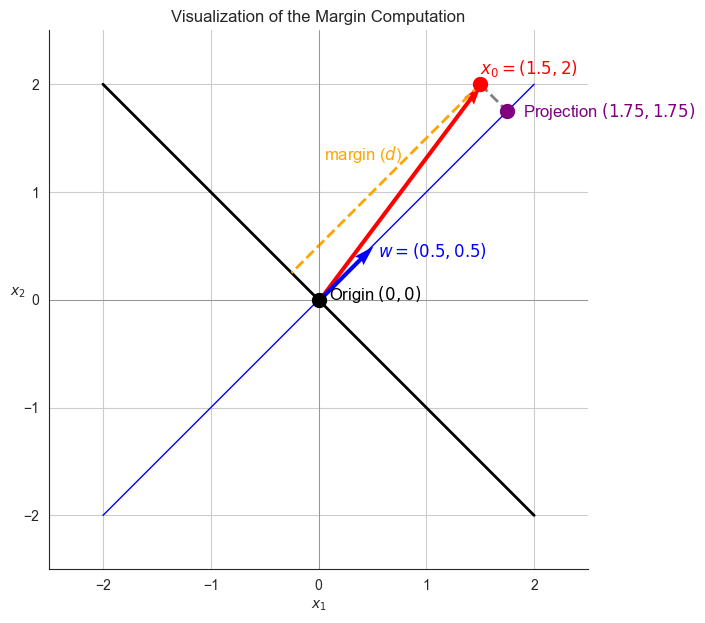

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define normal vector w and data point x_0
w = np.array([0.5, 0.5])  # Normal vector
point = np.array([1.5, 2])  # Data point

print(f"\nThe margin of {point} with weight {w} and bias 0 is {calculate_margin(point, w, 0)}\n")
# Compute projection onto w
dot_product_x0_w = np.dot(point, w)  
dot_product_w_w = np.dot(w, w)  
projection_scalar = dot_product_x0_w / dot_product_w_w  
projection_calculated = projection_scalar * w  

# Compute projection onto the decision boundary (where the margin meets the boundary)
b = 0  # Assume the decision boundary is w ⋅ x = 0 (passes through the origin)
projection_boundary = point - ((np.dot(point, w) + b) / np.dot(w, w)) * w  # Correct margin projection

# Define the decision boundary equation: x2 = -x1
x1_vals = np.linspace(-2, 2, 100)
x2_vals = -x1_vals  # Decision boundary

# Create visualization
fig, ax = plt.subplots(figsize=(7, 7))

# Plot decision boundary (black line)
ax.plot(x1_vals, x2_vals, 'k-', linewidth=2, label="Decision Boundary")

# Blue normal vector (extends beyond the projection point)
extended_w_start = np.array([-2, -2])  
extended_w_end = np.array([2, 2])  
ax.plot([extended_w_start[0], extended_w_end[0]], [extended_w_start[1], extended_w_end[1]], 'b-', linewidth=1, label="Normal Vector (w)")

# Red arrow pointing to data point
ax.quiver(0, 0, point[0], point[1], angles='xy', scale_units='xy', scale=1, color='red', label="Data Point $x_0 = (1.5,2)$")

# Corrected perpendicular margin line (orange dashed line from data point to decision boundary)
ax.plot([point[0], projection_boundary[0]], [point[1], projection_boundary[1]], linestyle='dashed', color='orange', linewidth=2, label="Margin (Perpendicular to Decision Boundary)")

# Perpendicular projection line from x_0 to the normal vector (gray dashed line)
ax.plot([point[0], projection_calculated[0]], [point[1], projection_calculated[1]], linestyle='dashed', color='gray', linewidth=2, label="Perpendicular to Normal Vector")

# Blue arrow representing the normal vector w at (0.5, 0.5)
ax.quiver(0, 0, w[0], w[1], angles='xy', scale_units='xy', scale=1, color='blue')

ax.text(0.55, 0.4, r"$w=(0.5, 0.5)$", fontsize=12, color='blue')
# Mark key points with labels
ax.text(1.5, 2.1, r"$x_0 = (1.5,2)$", fontsize=12, color='red')
ax.text(1.9, 1.7, r"Projection $(1.75, 1.75)$", fontsize=12, color='purple')
ax.text(0.1, 0, r"Origin $(0, 0)$", fontsize=12, color='black')

ax.text(0.05, 1.3, r"margin ($d$)", color='orange', fontsize=12)
# Plot key points
ax.scatter(point[0], point[1], color='red', s=100, zorder=3)  # Data point
ax.scatter(projection_calculated[0], projection_calculated[1], color='purple', s=100, zorder=3)  # Projection point
ax.scatter(0, 0, color='black', s=100, zorder=3)  # Projection point

# Labels and legend
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$", rotation=0)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
sns.despine()
#ax.legend(loc='upper right')
ax.set_title("Visualization of the Margin Computation")

# Enforce equal aspect ratio to maintain correct perpendicularity
ax.set_aspect('equal')

plt.grid()
plt.show()


An important observation is that the perceptron algorithm does not necessarily produce a decision boundary with the largest margin.  



Perceptron weights: [1. 1.],
Perceptron bias: -1


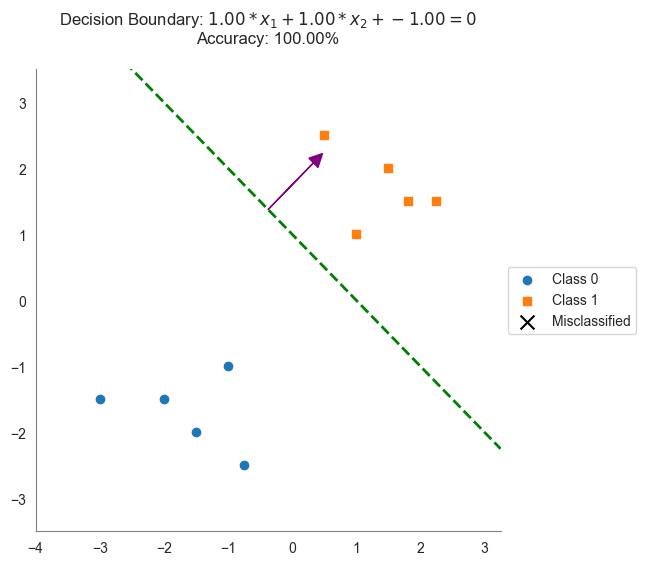

In [13]:

X1 = np.array([
    [-1, -1], [-2, -1.5], [-1.5, -2], [-0.75, -2.5], [-3, -1.5],  # Class 0
    [1, 1], [2.25, 1.5], [1.5, 2], [0.5, 2.5], [1.8, 1.5]  # Class 1
])
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])  # Labels

model_perceptron, best_w_perceptron, best_b_perceptron = train_perceptron(X1, y1, max_iters=1000)

print(f"\nPerceptron weights: {best_w_perceptron},\nPerceptron bias: {best_b_perceptron}")

plot_with_boundary(X1, y1, best_w_perceptron, best_b_perceptron)


## Support Vector Machines (SVMs)   

Support Vector Machines (SVMs) are an advanced method for determining an optimal decision boundary. Rather than just separating classes, an SVM maximizes the margin between them, which makes the classifier more robust and better at generalizing to new data. In this section, we will implement the SVM algorithm using the `keras` library.



### Hinge Loss

The SVM algorithm optimizes its decision boundary by minimizing the **hinge loss** function. Hinge loss penalizes predictions that are too close to—or on the wrong side of—the margin, encouraging the classifier to not only separate classes but also maximize the distance (margin) between them.

The hinge loss for a single data point is defined as:

$$
\text{hinge\_loss} = \max(0, 1 - y \cdot (w \cdot x + b)),
$$

where $y$ is the true label, $w$ is the weight vector, $x$ is the feature vector, and $b$ is the bias term. The hinge loss is zero when the point is correctly classified and on the correct side of the margin, and it increases linearly as the point moves closer to the decision boundary.



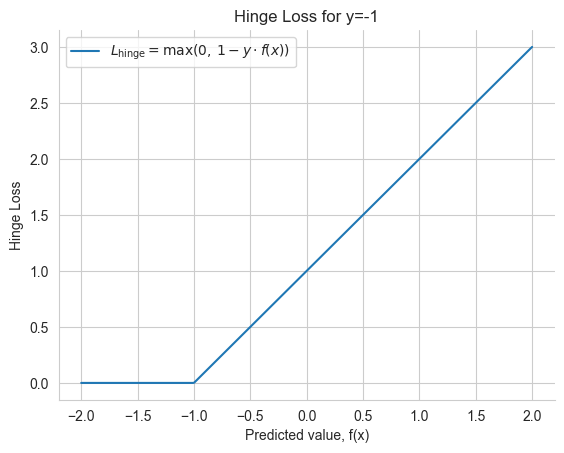

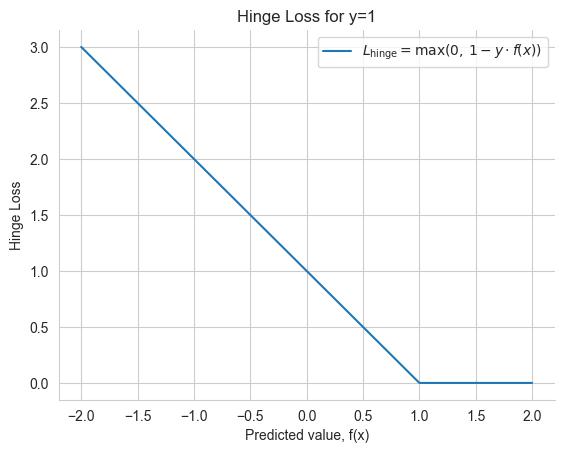

In [14]:

def hinge_loss_value(y, f):
    return np.maximum(0, 1 - y * f)

# Fix the true label 
y = -1

# Generate a range of predicted values
f_values = np.linspace(-2, 2, 400)
loss_values = hinge_loss_value(y, f_values)

sns.set_style('whitegrid')
plt.plot(f_values, loss_values, label=r'$L_{\text{hinge}} = \max(0,\, 1 - y\cdot f(x))$')
plt.xlabel('Predicted value, f(x)')
plt.ylabel('Hinge Loss')
plt.title(f'Hinge Loss for y={y}')
sns.despine()
plt.legend()
plt.grid(True)
plt.show()


# Fix the true label 
y = 1

# Generate a range of predicted values
f_values = np.linspace(-2, 2, 400)
loss_values = hinge_loss_value(y, f_values)

sns.set_style('whitegrid')
plt.plot(f_values, loss_values, label=r'$L_{\text{hinge}} = \max(0,\, 1 - y\cdot f(x))$')
plt.xlabel('Predicted value, f(x)')
plt.ylabel('Hinge Loss')
plt.title(f'Hinge Loss for y={y}')
sns.despine()
plt.legend()
plt.grid(True)
plt.show()


When training an SVM classifier, we will be finding the hinge loss for a *batch* of values.  The hinge loss for a batch of data points is the average of the hinge losses for each individual data point:

In [15]:
def hinge_loss_numpy(y_true, y_pred):
    # Ensure y_true and y_pred are numpy arrays of type float
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    # Calculate hinge loss for each sample: max(0, 1 - y * f(x))
    losses = np.maximum(0, 1 - y_true * y_pred)
    # Return the average loss
    return np.mean(losses)

# Example usage
y_true = np.array([-1, 1, -1, 1])
y_pred = np.array([0.8, 0.4, -0.5, 1.2])
print("NumPy Hinge Loss:", hinge_loss_numpy(y_true, y_pred))


NumPy Hinge Loss: 0.725


Hinge Loss (Average): 0.975


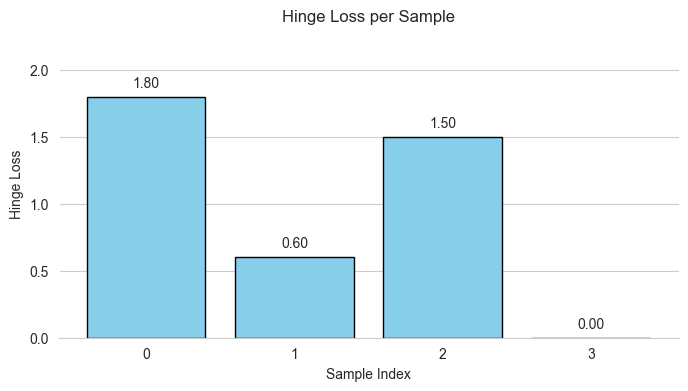

In [16]:
def hinge_loss_numpy_with_losses(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    losses = np.maximum(0, 1 - y_true * y_pred)
    return np.mean(losses), losses

y_true = np.array([-1, 1, 1, 1])
y_pred = np.array([0.8, 0.4, -0.5, 1.2])

avg_loss, losses = hinge_loss_numpy_with_losses(y_true, y_pred)
print("Hinge Loss (Average):", avg_loss)

# Bar plot for each sample's loss
plt.figure(figsize=(8, 4))
bars = plt.bar(np.arange(len(losses)), losses, color='skyblue', edgecolor='k')
plt.xlabel("Sample Index")
plt.ylabel("Hinge Loss")
plt.title("Hinge Loss per Sample")
plt.xticks(np.arange(len(losses)))

# Add labels above each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{losses[i]:.2f}',
             ha='center', va='bottom')

plt.ylim(0, max(losses) + 0.5)
plt.grid(axis='x')
sns.despine()
plt.gca().spines['left'].set_color('white')
plt.show()


In [17]:

## An interactive widget for exploring hinge loss

import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive_output, Layout
from IPython.display import display

def interactive_hinge_loss(y0, y1, y2, y3, p0, p1, p2, p3):
    # Construct arrays from widget inputs
    y_true = np.array([y0, y1, y2, y3])
    y_pred = np.array([p0, p1, p2, p3])
    
    # Compute hinge loss
    avg_loss, losses = hinge_loss_numpy_with_losses(y_true, y_pred)
    print("Hinge Loss (Average):", avg_loss)
    
    # Create bar plot for each sample's loss
    plt.figure(figsize=(8, 4))
    bars = plt.bar(np.arange(len(losses)), losses, color='skyblue', edgecolor='k')
    plt.xlabel("")
    plt.ylabel("Hinge Loss")
    plt.title("Hinge Loss per Sample")
    plt.xticks(np.arange(len(losses)))
    
    # Add text labels above each bar showing the loss value
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{losses[i]:.2f}',
                 ha='center', va='bottom')
    
    plt.ylim(0, 3.5)
    plt.grid(axis='x')
    sns.despine()  # Remove the top and right spines for a cleaner look
    plt.gca().spines['left'].set_color('white')
    #plt.show()

# Create widgets for each y (dropdown) and each p (slider)
w_y0 = widgets.Dropdown(options=[-1, 1], value=-1, description="y0:")
w_p0 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.8, description="p0:")

w_y1 = widgets.Dropdown(options=[-1, 1], value=1, description="y1:")
w_p1 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.4, description="p1:")

w_y2 = widgets.Dropdown(options=[-1, 1], value=1, description="y2:")
w_p2 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=-0.5, description="p2:")

w_y3 = widgets.Dropdown(options=[-1, 1], value=1, description="y3:")
w_p3 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1.2, description="p3:")


# Arrange the widgets into a 4x2 matrix (each row with y and p next to each other)
row0 = HBox([w_y0, w_p0], layout=Layout(margin='0px'))
row1 = HBox([w_y1, w_p1], layout=Layout(margin='0px'))
row2 = HBox([w_y2, w_p2], layout=Layout(margin='0px'))
row3 = HBox([w_y3, w_p3], layout=Layout(margin='0px'))

widget_matrix = VBox([row0, row1, row2, row3], layout=Layout(margin='0px'))
    
# Create an interactive output that links the widgets to the function
out = interactive_output(interactive_hinge_loss, 
                           {'y0': w_y0, 'p0': w_p0,
                            'y1': w_y1, 'p1': w_p1,
                            'y2': w_y2, 'p2': w_p2,
                            'y3': w_y3, 'p3': w_p3})

# Display the widget matrix and the output together
display(widget_matrix, out)



Output()

The `keras` library provides a built-in `Hinge` loss function that can be used to train SVM models. This loss function is defined as:

```python

tf.keras.losses.Hinge()

```


### Defining the SVM Classifier in Keras

There three steps to define and train an SVM classifier in Keras.

#### Step 1: Define the Model


In [18]:
import tensorflow as tf
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense


X = np.array([
    [-1, -1], [-2, -1.5], [-1.5, -2], [-0.75, -2.5], [-3, -1.5],  # Class 0
    [1, 1], [2.25, 1.5], [1.5, 2], [0.5, 2.5], [1.8, 1.5]  # Class 1
])

model = Sequential([
    Input(shape=(X.shape[1],)),  # Explicitly define the input shape
    Dense(1, activation='linear') # Linear activation for a linear classifier
])

model.summary()
print(model.layers[0].get_weights())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

[array([[ 1.397746 ],
       [-0.4976548]], dtype=float32), array([0.], dtype=float32)]


#### Step 2: Compile the Model

You must specify the loss function (we will use the built-in hinge loss function) and an *optimizer* that updates the weights based on the loss (more on this later).  

Optionally, you can also specify additional metrics to track during training.  For example, including 'accuracy' means that after each training epoch, Keras will calculate the percentage of predictions that match the true labels. This extra feedback helps you understand how well your model is performing and can guide decisions such as adjusting hyperparameters, selecting the best model, or diagnosing issues during training.


In [19]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
    )


#### Step 3: Train the Model

Training the model involves feeding the training data (features and labels) into the model and adjusting the weights to minimize the loss. The `fit` method in Keras is used to train the model. You must specify the training data, the number of epochs (iterations over the entire dataset), and the batch size (the number of samples used in each iteration).

Training complete


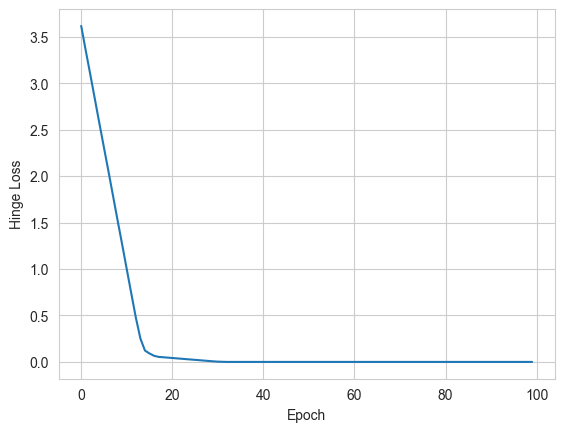

In [20]:
X1 = np.array([
    [-1, -1], [-2, -1.5], [-1.5, -2], [-0.75, -2.5], [-3, -1.5],  # Class 0
    [1, 1], [2.25, 1.5], [1.5, 2], [0.5, 2.5], [1.8, 1.5]  # Class 1
])
y1 = np.array([-1, -1, -1, -1,-1,  1, 1, 1, 1, 1])  # Labels

def build_model(input_dim):
    m = Sequential([
        Input(shape=(input_dim,)),
        Dense(1, activation='linear')
    ])
    m.compile(
        loss=tf.keras.losses.Hinge(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
    )
    return m

# Each time you want to start fresh:
model2 = build_model(X1.shape[1])

# Train the model
history = model2.fit(X1, y1, epochs=100,  batch_size = 2, verbose=0)
print("Training complete")

# Plot the loss over epochs
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss"); 


#### Make Predictions using the Model   

In [21]:
predictions = model2.predict(X1).flatten()

# Convert raw scores to class labels: if prediction >= 0, then class 1, else -1
predicted_labels = np.where(predictions >= 0, 1, -1)

print("Predictions:", predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predictions: [-1 -1 -1 -1 -1  1  1  1  1  1]


In [22]:
def train_svm(X, y, epochs, batch_size):
    """
    Build and train an SVM-like linear classifier using hinge loss.
    
    Parameters:
      X: NumPy array of input features (shape: (n_samples, n_features))
      y: NumPy array of labels (should be -1 and 1)
      epochs: Number of training epochs.
      batch_size: Batch size for training.
      
    Returns:
      predictor: A function that makes predictions on new data.
      w: Learned weight matrix from the Dense layer.
      b: Learned bias vector from the Dense layer.
    """
    
    # Build the model
    model = Sequential([
        Input(shape=(X.shape[1],)),         # Explicitly define input shape
        Dense(1, activation='linear')         # Single neuron (linear output)
    ])
    
    # Compile the model using hinge loss and SGD optimizer
    model.compile(
        loss=tf.keras.losses.Hinge(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
    )
    
    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Extract the learned weights and bias from the Dense layer.
    # (If using an Input layer, the Dense layer is typically the last layer.)
    w, b = model.layers[-1].get_weights()
    
    # Define a predictor function that mirrors your perceptron example:
    def predictor(X_new):
        # Compute the raw scores: f(x) = X_new.dot(w) + b.
        # Note: Ensure that X_new is a NumPy array.
        scores = np.dot(X_new, w) + b
        # Return class predictions: if score >= 0 then 1, else -1.
        return (scores >= 0).astype(int)
    
    return predictor, w.reshape(2), b


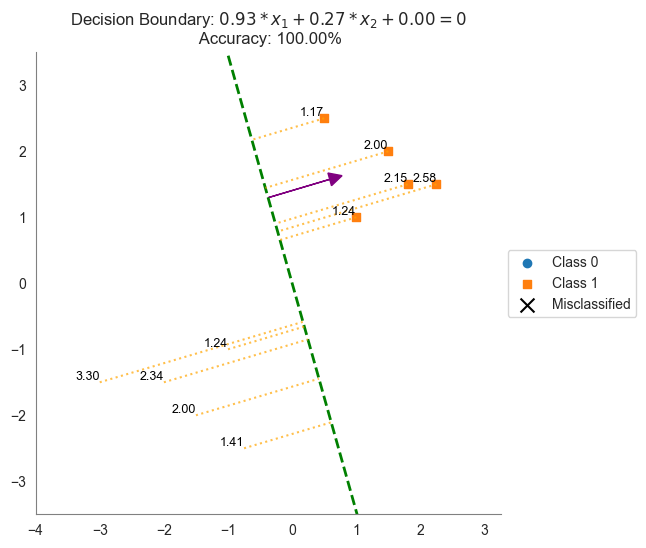

In [23]:
X1 = np.array([
    [-1, -1], [-2, -1.5], [-1.5, -2], [-0.75, -2.5], [-3, -1.5],  # Class 0
    [1, 1], [2.25, 1.5], [1.5, 2], [0.5, 2.5], [1.8, 1.5]  # Class 1
])
y1 = np.array([-1, -1, -1, -1, -1, 1, 1, 1, 1, 1])  # Labels

model_svm, best_w_svm, best_b_svm = train_svm(X1, y1, epochs=500, batch_size=5)
plot_with_boundary_and_margin(X1, y1, best_w_svm, best_b_svm[0])

